### Setup

#### Let's start by importing "all the things"

In [1]:
from fastai.vision.all import *

/Users/charlesfeinn/miniforge-pypy3/envs/fastai_lesson_3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/charlesfeinn/miniforge-pypy3/envs/fastai_lesson_3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <CC4BC91F-8B6A-3F9A-B9EB-A2B9D578E202> /Users/charlesfeinn/miniforge-pypy3/envs/fastai_lesson_3/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <408F81C0-C6C8-33EF-B02E-B683F7178A71> /Users/charlesfeinn/miniforge-pypy3/envs/fastai_lesson_3/lib/python3.9/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


#### Now let's print out our package versions
That way our git commits will contain the information necessary to troubleshoot any depenceny issues that arise.

We'll use a library I created, [pkg_vers](https://pypi.org/project/pkg-vers/), to do this quickly and easily.

In [2]:
!pip install -qq pkg_vers

In [3]:
import pkg_vers

notebook_path = 'lesson_3.ipynb'
imported_packages = pkg_vers.get_package_versions_from_ipynb(notebook_path)
for key, value in imported_packages.items():
    print(f"{key}: {value}")

itertools: 
pandas: 2.2.1
seaborn: 0.12.2
matplotlib: 3.8.0
fastai: 2.7.14
pkg_vers: 0.0.6
PIL: 10.2.0
csv: 1.0


Next let's setup the matplotlib runtime configuration to show images in grayscale 

In [4]:
matplotlib.rc('image', cmap='Greys')

### Data Preparation

#### Save & load

We'll add some functions to save and load our data locally. That way we don't need to keep downloading it while we play with hyperparameters, etc.

In [5]:
def on_disk(type_name):
    X_file_name = f'{type_name}_X.pt'
    y_file_name = f'{type_name}_y.pt'
    return os.path.exists(X_file_name) and os.path.exists(y_file_name)

In [6]:
def save_to_disk(data_name, X, y):
    X_file_name = f'{data_name}_X.pt'
    y_file_name = f'{data_name}_y.pt'
    torch.save(X, X_file_name)
    torch.save(y, y_file_name)


In [7]:
def load_from_disk(data_name):
    X_file_name = f'{data_name}_X.pt'
    y_file_name = f'{data_name}_y.pt'

    if on_disk(data_name):
        X = torch.load(X_file_name)
        y = torch.load(y_file_name)
        print(f"Loaded {data_name} data from disk")  
        return X, y

#### Download

In [8]:
# Setup our path to get the MNIST data
path = untar_data(URLs.MNIST)
print(path.ls())
print((path/'training').ls())

[Path('/Users/charlesfeinn/.fastai/data/mnist_png/training'), Path('/Users/charlesfeinn/.fastai/data/mnist_png/testing')]
[Path('/Users/charlesfeinn/.fastai/data/mnist_png/training/9'), Path('/Users/charlesfeinn/.fastai/data/mnist_png/training/0'), Path('/Users/charlesfeinn/.fastai/data/mnist_png/training/7'), Path('/Users/charlesfeinn/.fastai/data/mnist_png/training/6'), Path('/Users/charlesfeinn/.fastai/data/mnist_png/training/1'), Path('/Users/charlesfeinn/.fastai/data/mnist_png/training/8'), Path('/Users/charlesfeinn/.fastai/data/mnist_png/training/4'), Path('/Users/charlesfeinn/.fastai/data/mnist_png/training/3'), Path('/Users/charlesfeinn/.fastai/data/mnist_png/training/2'), Path('/Users/charlesfeinn/.fastai/data/mnist_png/training/5')]


In [9]:
print((path/'testing').ls())

[Path('/Users/charlesfeinn/.fastai/data/mnist_png/testing/9'), Path('/Users/charlesfeinn/.fastai/data/mnist_png/testing/0'), Path('/Users/charlesfeinn/.fastai/data/mnist_png/testing/7'), Path('/Users/charlesfeinn/.fastai/data/mnist_png/testing/6'), Path('/Users/charlesfeinn/.fastai/data/mnist_png/testing/1'), Path('/Users/charlesfeinn/.fastai/data/mnist_png/testing/8'), Path('/Users/charlesfeinn/.fastai/data/mnist_png/testing/4'), Path('/Users/charlesfeinn/.fastai/data/mnist_png/testing/3'), Path('/Users/charlesfeinn/.fastai/data/mnist_png/testing/2'), Path('/Users/charlesfeinn/.fastai/data/mnist_png/testing/5')]


In [10]:
def download_data(data_name, path):
    images = []
    labels = []
    for label in range(10):
        print(f"Loading {label}s...")
        image_paths = (path/data_name/f"{label}").ls()
        for image_path in image_paths:
            image_tensor = tensor(Image.open(image_path))
            images.append(image_tensor)
            labels.append(label)


    # Generally when images are floats, the pixel values are expected to be between 0 and 1, so we will also divide by 255 here:
    tensor_images = torch.stack(images).float()/255

    # unsqueeze() adds an extra dimension of depth 1
    tensor_labels = torch.tensor(labels, dtype=torch.long).unsqueeze(1)

    print(f"Loaded {data_name} data from the web") 
    return (tensor_images, tensor_labels)

#### Inspect

In [11]:
import matplotlib.pyplot as plt

def plot_images(images, image_indexes, page, true_labels=None, predicted_labels=None, index_mapping=None):
    plt.figure(figsize=(10, 4))
    n = len(images)
    page_size = 10
    for index in range(page_size):
        i = page_size * page + index

        ax = plt.subplot(2, page_size//2, index + 1)

        img = images[i]

        # Check if the image is a PyTorch tensor
        if isinstance(img, torch.Tensor):
            img = img.cpu().numpy()

        if len(img.shape) == 1:
                img = img.reshape(28, 28)

        plt.imshow(img, cmap='gray')
        title = ""
        if predicted_labels is not None:
            title += f"Pred: {predicted_labels[i][0].numpy()}"
        if predicted_labels is not None:
            title += f", True: {true_labels[i][0].numpy()}"
        if index_mapping is not None:
            training_set_index = image_indexes[i]
            unshuffled_index = index_mapping[training_set_index]
            subtitle = f"train_X idx: {training_set_index}\n"
            subtitle += f"train_X_original idx: {unshuffled_index}"

            # Add subtitle below the image
            ax.text(0.5, -0.4, subtitle, transform=ax.transAxes, ha='center', fontsize=10, color='blue')


        ax.set_title(title)
        plt.axis('off')
    plt.tight_layout(pad=2.0, h_pad=2.5)  # Adjusted padding to avoid overlap
    plt.show()

#### Prepare

In [12]:
def shuffle_data(X, y, misclassified_indices):
    number_of_examples = X.shape[0]

    indices = np.arange(number_of_examples)

    if misclassified_indices is not None and misclassified_indices.numel() > 0:
        indices = np.concatenate((indices[:(number_of_examples - misclassified_indices.shape[0])], misclassified_indices.numpy()))

    np.random.shuffle(indices)
    X_shuffled= X[indices]
    y_shuffled = y[indices]
    
    return X_shuffled, y_shuffled, indices.tolist()

In [75]:
from PIL import Image
import random

def random_transform(images, scale_options=(0.8, 2), rotation_angle=5):
    """
    Applies random transformations to a batch of images.

    Parameters:
        images (numpy.ndarray): Input array of shape (batch_size, height, width, channels).
        scale_options (tuple): A tuple containing the scaling factors to choose from.
        rotation_angle (int): Maximum rotation angle, rotation will be in the range [-C, C].

    Returns:
        numpy.ndarray: Array of transformed images with the same shape as input.
    """
    transformed_images = np.empty_like(images)
    for i, img in enumerate(images):
        if isinstance(img, torch.Tensor):
          img = img.numpy()

        # Convert numpy array to PIL Image
        img_pil = Image.fromarray(img)

        # Random rotation
        angle = random.uniform(-rotation_angle, rotation_angle)
        img_pil = img_pil.rotate(angle)

        # Random scaling
        if angle != 0:
          scale_factor = 1.1
        else:
          scale_factor = random.choice(scale_options)

        new_width = int(img_pil.width * scale_factor)
        new_height = int(img_pil.height * scale_factor)
        img_pil = img_pil.resize((new_width, new_height), Image.BILINEAR)

        # Center crop to the original dimensions
        left = (new_width - images.shape[2]) // 2
        top = (new_height - images.shape[1]) // 2
        right = left + images.shape[2]
        bottom = top + images.shape[1]
        img_pil = img_pil.crop((left, top, right, bottom))

        # Convert PIL Image back to numpy array and store in the transformed array
        img_pil = img_pil.resize((images.shape[1], images.shape[2]), Image.BILINEAR)  # Resize back to original dimensions
        transformed_images[i] = np.array(img_pil)

    return torch.from_numpy(transformed_images)

In [14]:
def augment_data(X, y, indices, number_of_augmentations_per_example):
    indexes = indices.copy()
    number_of_originals = X.shape[0]
    number_after_augmentation = number_of_augmentations_per_example * number_of_originals
    
    X_total = torch.empty((number_after_augmentation, X.shape[1], X.shape[2]))
    y_total = torch.empty((number_after_augmentation, y.shape[1]))

    for i in range(number_of_augmentations_per_example):
        X_augmented = random_transform(X)
        start_index = number_of_originals * i
        X_total[start_index : start_index + number_of_originals] = X_augmented
        y_total[start_index : start_index + number_of_originals] = y
        indexes += indices
    
    return X_total, y_total, indexes

In [15]:
def augment_example(X, y, rotation_angle):
    total_number = X.shape[0]
    X_augmented = random_transform(X, rotation_angle=rotation_angle)
    start_index = total_number * i
    X_total[start_index : start_index + total_number] = X_augmented
    y_total[start_index : start_index + total_number] = y
    indexes += indices


In [16]:
def add_misclassified(X, y, misclassified_data_name):

    misclassified_X_indices, misclassified_y = load_from_disk(misclassified_data_name)
    
    misclassified_X_indices = torch.tensor(misclassified_X_indices)  # Ensure indices are a tensor
    misclassified_X = torch.index_select(X, 0, misclassified_X_indices)
    misclassified_y = torch.tensor(misclassified_y).unsqueeze(1)

    # add another copy of the misclassified data to the dataset
    X = torch.cat((X, misclassified_X), dim=0)
    y = torch.cat((y, misclassified_y), dim=0)
    return X, y, misclassified_X_indices
        

### Model

In [17]:
def simple_net():
    return nn.Sequential(
        nn.Linear(28*28, 30),   # First layer takes 784 inputs from a flattened 28x28 image and outputs to 30 neurons
        nn.ReLU(),              # ReLU activation function
        nn.Linear(30, 10),      # Change this layer from outputting 1 to outputting 10 for digits 0-9
        nn.Softmax(dim=1)       # Softmax layer to convert the final layer outputs into probabilities
    )

### Train

#### Get the train and validation sets
If we've already prepared the data then we'll load it from disk. Otherwise we'll download, prepare things here, and save them to disk for future use.

In [18]:
def get_data(misclassified_data_name=None):
    train_data_name = 'train'
    validate_data_name = 'validate'

    if on_disk(train_data_name) and on_disk(validate_data_name):
        train_X_original, train_y_original = load_from_disk(train_data_name)
        validate_X, validate_y = load_from_disk(validate_data_name)

    else:
        train_X_original, train_y_original = download_data('training', path)
        save_to_disk(train_data_name, train_X_original, train_y_original)

        validate_X, validate_y = download_data('testing', path)
        save_to_disk(validate_data_name, validate_X, validate_y)
 
    # add the previously saved misclassified examples
    if misclassified_data_name and on_disk(misclassified_data_name):
        train_X, train_y, misclassified_indicies = add_misclassified(train_X_original, train_y_original, misclassified_data_name)
    else:
        train_X, train_y, misclassified_indicies = train_X_original, train_y_original, None

    # shuffle the original data
    train_X, train_y, train_inverse_index_mapping = shuffle_data(train_X, train_y, misclassified_indicies)

    # augment the data with variations
    number_of_variations = 2
    augmented_X, augmented_y, augmented_X_indices = augment_data(train_X, train_y, train_inverse_index_mapping, number_of_variations)

    # add the augmented data to the dataset
    train_X = torch.cat((train_X, augmented_X), dim=0)
    train_y = torch.cat((train_y, augmented_y), dim=0)
    train_inverse_index_mapping += augmented_X_indices

    # flatten from shape (number of examples, height=28, width=28) to (number of examples, 28*28)
    train_X = train_X.view(-1, 28*28)
    validate_X = validate_X.view(-1, 28*28)
    
    return (train_X, train_y, train_X_original, train_inverse_index_mapping), (validate_X, validate_y)

In [19]:
(X, y, train_X_original, train_inverse_index_mapping), (validate_X, validate_y) = get_data(misclassified_data_name=None)

Loaded train data from disk
Loaded validate data from disk


Let's check the shape of our data to make sure it looks right

In [20]:
X.shape, y.shape, validate_X.shape, validate_y.shape

(torch.Size([180000, 784]),
 torch.Size([180000, 1]),
 torch.Size([10000, 784]),
 torch.Size([10000, 1]))

Zip up our images and labels (as ints) into train and validate datasets

In [21]:
train_dataset = list(zip(X,y.long()))
validate_dataset = list(zip(validate_X, validate_y.long()))

#### Sanity check to make sure things are working

In [22]:
def display_image(example):
    if len(example.shape) == 1:
        # unflatten from 784 to 28x28
        example = example.reshape(28, 28)
    # convert back to uint8 and RGB scale 0-255
    image = (example*255).to(torch.uint8).numpy()
    return Image.fromarray(image)

In [23]:
import random

def load_random_example(dataset):
    random_example_number = random.randint(0,len(dataset)-1)
    example = dataset[random_example_number]
    X = example[0]
    y = example[1][0]
    if len(example) == 3:
        pred = example[2][0]
        print(f"label: {y}\npredicted: {pred}")
    else:
        print(f"label: {y}")
    return display_image(X)

In [24]:
load_random_example(train_dataset)

label: 2


#### Tooling

In [25]:
import csv

def write_losses_to(file_name, train_losses, accuracies, val_losses, **kwargs):
    with open(file_name, 'a', newline='') as file:
        writer = csv.writer(file)
        
        # Write header if the file is empty
        if file.tell() == 0:
            header = ['Epoch', 'Train Loss', 'Val Loss', 'Accuracies']
            header.extend(kwargs.keys())
            writer.writerow(header)
        
        # Write losses and additional parameters for each epoch
        for epoch in range(len(train_losses)):
            row = [epoch+1, train_losses[epoch], val_losses[epoch], accuracies[epoch]]
            row.extend(kwargs.values())
            writer.writerow(row)

In [26]:
import csv
import matplotlib.pyplot as plt

def plot_losses(row_number, file_name):
    train_losses = []
    val_losses = []
    epochs = []
    parameters = {}

    with open(file_name, 'r') as file:
        reader = csv.reader(file)
        header = next(reader)  # Read header row
        parameter_labels = header[3:]  # Get parameter labels from header
        
        for idx, row in enumerate(reader, start=1):
            if idx == row_number:
                epochs.append(int(row[0]))
                train_losses.append(float(row[1]))
                val_losses.append(float(row[2]))
                parameters = {label: value for label, value in zip(parameter_labels, row[3:])}
                break

    if not epochs:
        print(f"No data found for row number {row_number}")
        return

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    title = f'Train and Validation Losses (Row {row_number})\n'
    for label, value in parameters.items():
        title += f'{label}: {value}, '
    title = title.rstrip(', ')
    
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

#### Configure the model

In [27]:
def mnist_loss(predicted_probabilities, targets):
    # Define the loss function
    loss_function = nn.CrossEntropyLoss()

    # Squeeze the targets tensor to remove the extra dimension
    targets = targets.squeeze(1)  # This changes shape from [100, 1] to [100]

    # Calculate the loss
    loss = loss_function(predicted_probabilities, targets)
    return loss

In [28]:
def batch_accuracy(xb, yb):
    
    right = 0
    total = len(xb)
    for i in range(total):
        example_x = xb[i]
        example_y = yb[i].item()

        _, predicted_label = torch.max(example_x, 0)  # 0 is the dimension along which to find the max

        if predicted_label == example_y:
            right += 1
    
    return right / total

In [29]:
# Log the initial accuracy before training
def log_initial_accuracy(learner):
    learner.model.eval()  # Set the model to evaluation mode
    val_loss, val_acc = learner.validate()
    print(f"Initial accuracy: {val_acc}")

In [30]:
def create_learner(train_dataset, validate_dataset, batch_size, model, loss_func, optimization_function, metrics):
    data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    validation_data_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
    data_loaders = DataLoaders(data_loader, validation_data_loader)

    learner = Learner(dls=data_loaders, model=model, loss_func=loss_func, opt_func=optimization_function, metrics=metrics)
    return learner 

    # learner = Learner(
    #     dls: DataLoaders, 
    #     model: Any, 
    #     loss_func: Any | None = None, 
    #     opt_func: Optimizer | OptimWrapper = Adam, 
    #     lr: float | slice = defaults.lr, 
    #     splitter: Any = trainable_params, 
    #     cbs: Callback | MutableSequence | None = None, 
    #     metrics: Any | MutableSequence | None = None, 
    #     path: str | Path | None = None, 
    #     model_dir: str | Path = 'models', 
    #     wd: float | int | None = None, 
    #     wd_bn_bias: bool = False, 
    #     train_bn: bool = True, 
    #     moms: tuple = (0.95, 0.85, 0.95), 
    #     default_cbs: bool = True
    # )

In [31]:
def evaluate_model(train_dataset, validate_dataset, lr, batch_size, opt_func, n_epochs, losses_file_name=None, param_dict={}):
    model = simple_net()
    learner = create_learner(train_dataset, validate_dataset, batch_size, model, mnist_loss, opt_func, [batch_accuracy])
    log_initial_accuracy(learner)
    learner.fit(n_epochs, lr=lr)
    train_losses, val_losses, accuracies = zip(*learner.recorder.values)
    if losses_file_name:
        write_losses_to(losses_file_name, train_losses, val_losses, accuracies, **param_dict)

    return learner, learner.validate()[1]

#### Train the model

Now lets define some hyperparameters

In [32]:
learning_rate = 0.001
batch_size = 32
opt_func = SGD
n_epochs = 1

In [33]:
_, val_accuracy = evaluate_model(train_dataset, validate_dataset, learning_rate, batch_size, opt_func, n_epochs)
print(f"Accuracy: {val_accuracy}")

Initial accuracy: 0.0991


epoch,train_loss,valid_loss,batch_accuracy,time
0,2.288624,2.289046,0.265300,00:09


Accuracy: 0.2653


### Grid search

Now that we have a working model lets add a grid search to find the best hyperparameters to use.

#### Grid search tooling

In [34]:
import csv

def save_grid_search_result_to_csv(results_file_name, accuracy, **kwargs):
    # Open the file in append mode
    with open(results_file_name, 'a', newline='') as file:
        # Create a CSV writer object
        writer = csv.writer(file)
        
        # Write header if the file is empty
        if file.tell() == 0:
            header = list(kwargs.keys()) + ['accuracy']
            writer.writerow(header)

        parameters = [(value.__name__ if callable(value) else value) for value in kwargs.values()]
        row = parameters + [accuracy]

        writer.writerow(row)

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_grid_search_results(file_name):
    # Load the results from the CSV file
    df = pd.read_csv(file_name)

     # Create pivot table
    pivot_table = df.pivot_table(index='lr', columns=['batch_size', 'opt_func'], values='accuracy', aggfunc='mean')
    
    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, cmap='coolwarm', linewidths=0.5, cbar_kws={'label': 'Accuracy'})
    plt.title('Grid Search Results')
    plt.xlabel('Batch Size, Optimizer')
    plt.ylabel('Learning Rate')
    plt.show()

    # plt.figure(figsize=(10, 8))
    # sns.heatmap(df.pivot_table(index='lr', columns='batch_size', values='accuracy', aggfunc='mean'),
    #             annot=True, cmap='coolwarm', linewidths=0.5, cbar_kws={'label': 'Accuracy'})
    # plt.title('Grid Search Results')
    # plt.xlabel('Batch Size')
    # plt.ylabel('Learning Rate')
    # plt.show()

#### Grid search

In [36]:
import itertools
def grid_search(param_grid, train_dataset, validate_dataset, results_file_name, losses_file_name, learner_file_name):
    best_params = None
    best_accuracy = 0.0

    # Load the best accuracy from the grid_search_results.csv file
    if os.path.exists(results_file_name):
        with open(results_file_name, 'r') as file:
            reader = csv.DictReader(file)
            best_result = max(reader, key=lambda row: float(row['accuracy']))
            best_accuracy = float(best_result['accuracy'])
            print(f"asdf: {best_accuracy}")

    # Generate all possible combinations of hyperparameters
    param_combinations = itertools.product(*param_grid.values())

    for params in param_combinations:
        lr, batch_size, opt_func, n_epochs, run = params
        print(f"Evaluating: lr={lr}, batch_size={batch_size}, opt_func={opt_func.__name__}, n_epochs={n_epochs}, run={run}")

        param_dict = dict(zip(param_grid.keys(), params))
        learner, val_accuracy = evaluate_model(train_dataset, validate_dataset, lr, batch_size, opt_func, n_epochs, losses_file_name, param_dict)
        print(f"Accuracy: {val_accuracy}")

        save_grid_search_result_to_csv(results_file_name, val_accuracy, **param_dict)

        if val_accuracy > best_accuracy:
            if learner_file_name and val_accuracy > best_accuracy:
                torch.save(learner, learner_file_name)
            
            best_params = params
            best_accuracy = val_accuracy

    return best_params, best_accuracy

In [39]:
param_grid = {
    'lr': [0.00075, 0.0015, 0.0025],
    'batch_size': [32, 64, 128],
    'opt_func': [Adam, SGD],
    'n_epochs': [5, 8, 11],
    'runs': [1]#1, 2, 3, 4] # try 4 weight initalizations for each  
}

In [40]:
learner_file_name = 'best_learner.pt'
# Run the grid search
best_params, best_accuracy = grid_search(param_grid, train_dataset, validate_dataset, 'grid_search_results.csv', 'losses.csv', learner_file_name)
print(f"Best hyperparameters: {best_params}")
print(f"Best accuracy: {best_accuracy}")

asdf: 0.93
Evaluating: lr=0.00075, batch_size=32, opt_func=Adam, n_epochs=5, run=1


Initial accuracy: 0.0824


epoch,train_loss,valid_loss,batch_accuracy,time
0,1.535614,1.539427,0.930000,00:10
1,1.519804,1.533627,0.932300,00:13
2,1.511335,1.529788,0.937400,00:12
3,1.505340,1.524768,0.942000,00:12
4,1.501983,1.519459,0.945800,00:12


Accuracy: 0.9458
Evaluating: lr=0.00075, batch_size=32, opt_func=Adam, n_epochs=8, run=1


Initial accuracy: 0.0939


epoch,train_loss,valid_loss,batch_accuracy,time
0,1.617496,1.620428,0.846100,00:13
1,1.600259,1.610765,0.853700,00:13
2,1.511756,1.531845,0.936300,00:12
3,1.503204,1.521010,0.945600,00:13
4,1.498313,1.515221,0.949500,00:12
5,1.495732,1.513543,0.951600,00:13
6,1.493548,1.513476,0.952200,00:13
7,1.491832,1.513574,0.952000,00:13


Accuracy: 0.952
Evaluating: lr=0.00075, batch_size=32, opt_func=Adam, n_epochs=11, run=1


Initial accuracy: 0.0848


epoch,train_loss,valid_loss,batch_accuracy,time
0,1.540628,1.543422,0.925600,00:11
1,1.522550,1.536585,0.930000,00:12
2,1.513116,1.533127,0.933400,00:12
3,1.506545,1.526120,0.939700,00:12
4,1.501491,1.521801,0.944100,00:13
5,1.498695,1.520218,0.945000,00:13
6,1.496657,1.519973,0.945600,00:12
7,1.495351,1.516461,0.947900,00:12
8,1.493790,1.514872,0.949800,00:12
9,1.492081,1.514913,0.949300,00:12


Accuracy: 0.9515
Evaluating: lr=0.00075, batch_size=32, opt_func=SGD, n_epochs=5, run=1


Initial accuracy: 0.0893


epoch,train_loss,valid_loss,batch_accuracy,time
0,2.295703,2.295473,0.210200,00:09
1,2.283332,2.283237,0.374300,00:11
2,2.256500,2.256393,0.390700,00:11
3,2.187222,2.186261,0.371200,00:11
4,2.107608,2.105795,0.437200,00:11


Accuracy: 0.4372
Evaluating: lr=0.00075, batch_size=32, opt_func=SGD, n_epochs=8, run=1


Initial accuracy: 0.0872


epoch,train_loss,valid_loss,batch_accuracy,time
0,2.292449,2.292812,0.266700,00:11
1,2.274389,2.274615,0.326200,00:09
2,2.234092,2.233250,0.339300,00:09
3,2.181337,2.181445,0.450800,00:10
4,2.105122,2.107068,0.509400,00:10
5,2.016402,2.022366,0.545200,00:10
6,1.955531,1.961445,0.615000,00:09
7,1.894210,1.900136,0.654600,00:09


Accuracy: 0.6546
Evaluating: lr=0.00075, batch_size=32, opt_func=SGD, n_epochs=11, run=1


Initial accuracy: 0.0932


epoch,train_loss,valid_loss,batch_accuracy,time
0,2.295434,2.295920,0.292800,00:09
1,2.282688,2.283321,0.366600,00:09
2,2.253072,2.253545,0.319300,00:09
3,2.194600,2.193788,0.347800,00:09
4,2.125431,2.124348,0.408600,00:09
5,2.055495,2.054794,0.464500,00:09
6,2.000619,1.998910,0.524900,00:09
7,1.942325,1.938738,0.613100,00:09
8,1.905895,1.899280,0.627900,00:09
9,1.883404,1.874516,0.636100,00:09


Accuracy: 0.6423
Evaluating: lr=0.00075, batch_size=64, opt_func=Adam, n_epochs=5, run=1


Initial accuracy: 0.1045


epoch,train_loss,valid_loss,batch_accuracy,time
0,1.544963,1.547199,0.923100,00:06
1,1.526981,1.537419,0.929900,00:06
2,1.516767,1.532968,0.932400,00:06
3,1.510657,1.527153,0.938700,00:06
4,1.506317,1.523752,0.941900,00:06


Accuracy: 0.9419
Evaluating: lr=0.00075, batch_size=64, opt_func=Adam, n_epochs=8, run=1


Initial accuracy: 0.107


epoch,train_loss,valid_loss,batch_accuracy,time
0,1.544109,1.545300,0.926800,00:06
1,1.528115,1.536265,0.931000,00:06
2,1.519369,1.533468,0.933200,00:06
3,1.513024,1.530110,0.935500,00:06
4,1.509207,1.527729,0.937200,00:06
5,1.505481,1.522134,0.943800,00:06
6,1.502344,1.518291,0.946400,00:06
7,1.499589,1.516505,0.948400,00:06


Accuracy: 0.9484
Evaluating: lr=0.00075, batch_size=64, opt_func=Adam, n_epochs=11, run=1


Initial accuracy: 0.0793


epoch,train_loss,valid_loss,batch_accuracy,time
0,1.546465,1.551004,0.919300,00:06
1,1.528641,1.536310,0.931200,00:06
2,1.518989,1.529846,0.937500,00:06
3,1.512324,1.525514,0.942100,00:06
4,1.507719,1.520101,0.946200,00:06
5,1.504193,1.516165,0.950100,00:06
6,1.501672,1.513893,0.951400,00:06
7,1.498608,1.511398,0.954700,00:06
8,1.496116,1.511012,0.954000,00:06
9,1.493827,1.509524,0.955800,00:07


Accuracy: 0.9578
Evaluating: lr=0.00075, batch_size=64, opt_func=SGD, n_epochs=5, run=1


Initial accuracy: 0.1008


epoch,train_loss,valid_loss,batch_accuracy,time
0,2.297466,2.297819,0.101300,00:04
1,2.292346,2.292846,0.148600,00:04
2,2.285582,2.286260,0.338100,00:05
3,2.276310,2.277245,0.442200,00:05
4,2.262004,2.263268,0.465800,00:05


Accuracy: 0.4658
Evaluating: lr=0.00075, batch_size=64, opt_func=SGD, n_epochs=8, run=1


Initial accuracy: 0.0775


epoch,train_loss,valid_loss,batch_accuracy,time
0,2.299404,2.299497,0.167600,00:05
1,2.295480,2.295546,0.282900,00:05
2,2.290393,2.290443,0.346100,00:05
3,2.283743,2.283788,0.371500,00:06
4,2.274482,2.274511,0.385400,00:06
5,2.259947,2.259918,0.386300,00:06
6,2.236176,2.235852,0.381600,00:05
7,2.204767,2.204611,0.401500,00:05


Accuracy: 0.4015
Evaluating: lr=0.00075, batch_size=64, opt_func=SGD, n_epochs=11, run=1


Initial accuracy: 0.0628


epoch,train_loss,valid_loss,batch_accuracy,time
0,2.299382,2.299414,0.149200,00:05
1,2.293843,2.294123,0.224400,00:05
2,2.285680,2.286015,0.261500,00:05
3,2.272491,2.272595,0.271500,00:05
4,2.252041,2.251549,0.273300,00:05
5,2.230345,2.229907,0.267900,00:05
6,2.208653,2.209422,0.259600,00:05
7,2.188254,2.190163,0.291100,00:05
8,2.167048,2.169756,0.351300,00:05
9,2.139349,2.142834,0.388700,00:04


Accuracy: 0.3959
Evaluating: lr=0.00075, batch_size=128, opt_func=Adam, n_epochs=5, run=1


Initial accuracy: 0.0854


epoch,train_loss,valid_loss,batch_accuracy,time
0,1.554136,1.557516,0.914100,00:03
1,1.535932,1.542907,0.925300,00:03
2,1.526518,1.539171,0.928500,00:03
3,1.520392,1.535042,0.931200,00:03
4,1.515306,1.530740,0.935700,00:03


Accuracy: 0.9357
Evaluating: lr=0.00075, batch_size=128, opt_func=Adam, n_epochs=8, run=1


Initial accuracy: 0.1539


epoch,train_loss,valid_loss,batch_accuracy,time
0,1.556561,1.560171,0.912900,00:03
1,1.540650,1.547032,0.921500,00:03
2,1.531084,1.541278,0.927000,00:03
3,1.523786,1.537815,0.928400,00:03
4,1.517962,1.533576,0.930900,00:03
5,1.513321,1.528324,0.936600,00:03
6,1.509716,1.525021,0.939800,00:03
7,1.506636,1.522370,0.943200,00:03


Accuracy: 0.9432
Evaluating: lr=0.00075, batch_size=128, opt_func=Adam, n_epochs=11, run=1


Initial accuracy: 0.1073


epoch,train_loss,valid_loss,batch_accuracy,time
0,1.554976,1.557840,0.913800,00:03
1,1.538059,1.544496,0.924900,00:03
2,1.527522,1.540360,0.928100,00:03
3,1.519434,1.535572,0.931300,00:03
4,1.513496,1.532189,0.934200,00:03
5,1.508943,1.527319,0.938600,00:03
6,1.505814,1.523372,0.942200,00:03
7,1.503367,1.522039,0.943800,00:03
8,1.501350,1.521570,0.943300,00:03
9,1.499648,1.520080,0.943700,00:03


Accuracy: 0.9471
Evaluating: lr=0.00075, batch_size=128, opt_func=SGD, n_epochs=5, run=1


Initial accuracy: 0.1236


epoch,train_loss,valid_loss,batch_accuracy,time
0,2.301168,2.301487,0.177500,00:03
1,2.299440,2.299820,0.241000,00:03
2,2.297459,2.297922,0.281500,00:03
3,2.295162,2.295722,0.309000,00:03
4,2.292528,2.293193,0.321400,00:03


Accuracy: 0.3214
Evaluating: lr=0.00075, batch_size=128, opt_func=SGD, n_epochs=8, run=1


Initial accuracy: 0.1429


epoch,train_loss,valid_loss,batch_accuracy,time
0,2.300676,2.300437,0.194100,00:02
1,2.298394,2.298066,0.256200,00:02
2,2.295785,2.295377,0.309300,00:02
3,2.292802,2.292356,0.348700,00:02
4,2.289429,2.288985,0.391800,00:02
5,2.285629,2.285187,0.432000,00:03
6,2.281200,2.280751,0.469200,00:03
7,2.275806,2.275369,0.502500,00:03


Accuracy: 0.5025
Evaluating: lr=0.00075, batch_size=128, opt_func=SGD, n_epochs=11, run=1


Initial accuracy: 0.113


epoch,train_loss,valid_loss,batch_accuracy,time
0,2.301538,2.301476,0.123500,00:03
1,2.300074,2.300012,0.136600,00:03
2,2.298312,2.298246,0.155000,00:03
3,2.296233,2.296160,0.182700,00:03
4,2.293841,2.293784,0.218500,00:03
5,2.291101,2.291090,0.259600,00:03
6,2.287985,2.288033,0.304300,00:03
7,2.284436,2.284552,0.352500,00:03
8,2.280335,2.280535,0.378300,00:03
9,2.275490,2.275792,0.391700,00:03


Accuracy: 0.3927
Evaluating: lr=0.0015, batch_size=32, opt_func=Adam, n_epochs=5, run=1


Initial accuracy: 0.1486


epoch,train_loss,valid_loss,batch_accuracy,time
0,1.528917,1.530985,0.933600,00:12
1,1.515211,1.524961,0.940100,00:13
2,1.506418,1.516881,0.947500,00:13
3,1.499256,1.515200,0.947600,00:13
4,1.497121,1.511340,0.952200,00:12


Accuracy: 0.9522
Evaluating: lr=0.0015, batch_size=32, opt_func=Adam, n_epochs=8, run=1


Initial accuracy: 0.1196


epoch,train_loss,valid_loss,batch_accuracy,time
0,1.525102,1.532908,0.932600,00:12
1,1.507913,1.523703,0.940400,00:13
2,1.500650,1.513091,0.950700,00:12
3,1.496638,1.512457,0.951000,00:12
4,1.494290,1.508448,0.955000,00:12
5,1.491472,1.512426,0.951600,00:12
6,1.489658,1.507814,0.956100,00:13
7,1.486883,1.507823,0.956000,00:13


Accuracy: 0.956
Evaluating: lr=0.0015, batch_size=32, opt_func=Adam, n_epochs=11, run=1


Initial accuracy: 0.0614


epoch,train_loss,valid_loss,batch_accuracy,time
0,1.531332,1.534760,0.931600,00:12
1,1.513628,1.525729,0.939300,00:12
2,1.506034,1.519089,0.943600,00:13
3,1.501544,1.516986,0.946300,00:12
4,1.498495,1.509960,0.954000,00:13
5,1.495093,1.506823,0.956500,00:13
6,1.492538,1.510516,0.952600,00:14
7,1.490742,1.508632,0.955300,00:12
8,1.489784,1.514737,0.948100,00:11
9,1.489417,1.508535,0.954700,00:11


Accuracy: 0.9557
Evaluating: lr=0.0015, batch_size=32, opt_func=SGD, n_epochs=5, run=1


Initial accuracy: 0.0838


epoch,train_loss,valid_loss,batch_accuracy,time
0,2.284568,2.285408,0.450700,00:09
1,2.219122,2.219387,0.451000,00:09
2,2.049851,2.054899,0.524000,00:08
3,1.887643,1.891204,0.693700,00:09
4,1.815983,1.816011,0.720400,00:08


Accuracy: 0.7204
Evaluating: lr=0.0015, batch_size=32, opt_func=SGD, n_epochs=8, run=1


Initial accuracy: 0.1032


epoch,train_loss,valid_loss,batch_accuracy,time
0,2.285526,2.285166,0.232300,00:08
1,2.211772,2.209576,0.348900,00:08
2,2.075521,2.078154,0.472700,00:08
3,1.981915,1.984501,0.522100,00:08
4,1.896469,1.897287,0.641000,00:08
5,1.812340,1.813002,0.724200,00:08
6,1.776751,1.775305,0.734100,00:08
7,1.759836,1.756771,0.739100,00:08


Accuracy: 0.7391
Evaluating: lr=0.0015, batch_size=32, opt_func=SGD, n_epochs=11, run=1


Initial accuracy: 0.0949


epoch,train_loss,valid_loss,batch_accuracy,time
0,2.280557,2.280520,0.237700,00:08
1,2.212204,2.212312,0.428900,00:08
2,2.032641,2.035114,0.560100,00:08
3,1.884817,1.884076,0.700600,00:08
4,1.815139,1.809305,0.720600,00:08
5,1.787687,1.779221,0.730200,00:08
6,1.772383,1.762387,0.734800,00:08
7,1.762348,1.751416,0.739000,00:08
8,1.755148,1.743620,0.742100,00:08
9,1.749619,1.737716,0.743600,00:08


Accuracy: 0.7453
Evaluating: lr=0.0015, batch_size=64, opt_func=Adam, n_epochs=5, run=1


Initial accuracy: 0.0762


epoch,train_loss,valid_loss,batch_accuracy,time
0,1.533491,1.535078,0.932200,00:05
1,1.517030,1.524378,0.941700,00:05
2,1.510477,1.519689,0.944100,00:05
3,1.505683,1.516957,0.946200,00:05
4,1.501639,1.513958,0.949700,00:05


Accuracy: 0.9497
Evaluating: lr=0.0015, batch_size=64, opt_func=Adam, n_epochs=8, run=1


Initial accuracy: 0.109


epoch,train_loss,valid_loss,batch_accuracy,time
0,1.530133,1.535522,0.931200,00:05
1,1.514943,1.526779,0.937700,00:05
2,1.505184,1.520271,0.945300,00:06
3,1.498695,1.513057,0.951900,00:06
4,1.495526,1.509806,0.953300,00:06
5,1.492434,1.507242,0.956900,00:06
6,1.489979,1.506132,0.956900,00:05
7,1.488789,1.504817,0.958600,00:06


Accuracy: 0.9586
Evaluating: lr=0.0015, batch_size=64, opt_func=Adam, n_epochs=11, run=1


Initial accuracy: 0.0701


epoch,train_loss,valid_loss,batch_accuracy,time
0,1.534389,1.542077,0.924600,00:05
1,1.516184,1.530004,0.935500,00:05
2,1.508221,1.519112,0.945700,00:06
3,1.503157,1.514948,0.949000,00:06
4,1.499168,1.516394,0.947400,00:06
5,1.495791,1.512844,0.951000,00:06
6,1.494229,1.512711,0.950800,00:06
7,1.492589,1.512802,0.949200,00:05
8,1.491100,1.512484,0.949900,00:05
9,1.490030,1.512478,0.949300,00:06


Accuracy: 0.9495
Evaluating: lr=0.0015, batch_size=64, opt_func=SGD, n_epochs=5, run=1


Initial accuracy: 0.0724


epoch,train_loss,valid_loss,batch_accuracy,time
0,2.296756,2.296967,0.267400,00:04
1,2.286174,2.286749,0.422300,00:04
2,2.267599,2.268590,0.501900,00:04
3,2.225978,2.227810,0.545500,00:05
4,2.132961,2.134681,0.547500,00:05


Accuracy: 0.5475
Evaluating: lr=0.0015, batch_size=64, opt_func=SGD, n_epochs=8, run=1


Initial accuracy: 0.1156


epoch,train_loss,valid_loss,batch_accuracy,time
0,2.295154,2.295193,0.269900,00:05
1,2.280828,2.281090,0.381800,00:05
2,2.252909,2.253927,0.451500,00:04
3,2.183313,2.186024,0.502700,00:04
4,2.069410,2.076208,0.532500,00:04
5,1.979523,1.988514,0.560600,00:04
6,1.937252,1.944863,0.568100,00:04
7,1.916723,1.922895,0.572200,00:04


Accuracy: 0.5722
Evaluating: lr=0.0015, batch_size=64, opt_func=SGD, n_epochs=11, run=1


Initial accuracy: 0.1156


epoch,train_loss,valid_loss,batch_accuracy,time
0,2.296495,2.297040,0.264800,00:05
1,2.286643,2.287510,0.331200,00:04
2,2.270346,2.271506,0.397300,00:04
3,2.229330,2.230705,0.374600,00:05
4,2.172356,2.175989,0.399400,00:05
5,2.106284,2.112968,0.452200,00:04
6,2.031924,2.039881,0.480700,00:04
7,1.990275,1.997368,0.489900,00:04
8,1.957857,1.963449,0.543500,00:04
9,1.921221,1.925138,0.626500,00:04


Accuracy: 0.6835
Evaluating: lr=0.0015, batch_size=128, opt_func=Adam, n_epochs=5, run=1


Initial accuracy: 0.1032


epoch,train_loss,valid_loss,batch_accuracy,time
0,1.543590,1.547242,0.922300,00:03
1,1.525954,1.536432,0.929600,00:03
2,1.516011,1.530395,0.934300,00:03
3,1.508587,1.521837,0.943900,00:03
4,1.504133,1.519314,0.945100,00:03


Accuracy: 0.9451
Evaluating: lr=0.0015, batch_size=128, opt_func=Adam, n_epochs=8, run=1


Initial accuracy: 0.1457


epoch,train_loss,valid_loss,batch_accuracy,time
0,1.537458,1.540391,0.929700,00:03
1,1.520465,1.534030,0.931800,00:03
2,1.512314,1.529846,0.935400,00:03
3,1.507306,1.525118,0.939100,00:03
4,1.503619,1.521828,0.942700,00:03
5,1.500328,1.521552,0.943300,00:03
6,1.497977,1.519656,0.945200,00:03
7,1.495972,1.515796,0.949000,00:03


Accuracy: 0.949
Evaluating: lr=0.0015, batch_size=128, opt_func=Adam, n_epochs=11, run=1


Initial accuracy: 0.0938


epoch,train_loss,valid_loss,batch_accuracy,time
0,1.538022,1.539268,0.931000,00:03
1,1.518616,1.531500,0.934800,00:03
2,1.509515,1.521343,0.942800,00:03
3,1.502995,1.517486,0.947400,00:03
4,1.498963,1.514493,0.951300,00:03
5,1.495441,1.509797,0.955300,00:03
6,1.493418,1.508255,0.955900,00:03
7,1.491490,1.507328,0.956800,00:03
8,1.488903,1.506516,0.956800,00:03
9,1.487190,1.506301,0.956500,00:03


Accuracy: 0.9586
Evaluating: lr=0.0015, batch_size=128, opt_func=SGD, n_epochs=5, run=1


Initial accuracy: 0.078


epoch,train_loss,valid_loss,batch_accuracy,time
0,2.298719,2.299015,0.110100,00:02
1,2.294433,2.294848,0.186300,00:02
2,2.288785,2.289324,0.263200,00:02
3,2.281181,2.281790,0.316100,00:02
4,2.269932,2.270678,0.334900,00:02


Accuracy: 0.3349
Evaluating: lr=0.0015, batch_size=128, opt_func=SGD, n_epochs=8, run=1


Initial accuracy: 0.0881


epoch,train_loss,valid_loss,batch_accuracy,time
0,2.298658,2.298591,0.122500,00:02
1,2.293918,2.293945,0.166100,00:02
2,2.287695,2.287809,0.301600,00:02
3,2.279091,2.279210,0.429900,00:02
4,2.266520,2.266539,0.498800,00:03
5,2.246045,2.245771,0.455400,00:03
6,2.219859,2.219412,0.465900,00:03
7,2.189277,2.189511,0.508500,00:02


Accuracy: 0.5085
Evaluating: lr=0.0015, batch_size=128, opt_func=SGD, n_epochs=11, run=1


Initial accuracy: 0.0928


epoch,train_loss,valid_loss,batch_accuracy,time
0,2.298208,2.298414,0.204000,00:03
1,2.292909,2.293314,0.281200,00:03
2,2.286301,2.286943,0.341400,00:03
3,2.277275,2.278198,0.336500,00:03
4,2.262414,2.263717,0.301900,00:02
5,2.237627,2.239274,0.284200,00:02
6,2.208700,2.210730,0.303000,00:02
7,2.180941,2.183816,0.327700,00:02
8,2.153516,2.157766,0.356000,00:02
9,2.123523,2.129563,0.417300,00:02


Accuracy: 0.503
Evaluating: lr=0.0025, batch_size=32, opt_func=Adam, n_epochs=5, run=1


Initial accuracy: 0.0824


epoch,train_loss,valid_loss,batch_accuracy,time
0,1.518512,1.530199,0.933000,00:10
1,1.507489,1.519858,0.944200,00:11
2,1.502239,1.513053,0.949100,00:10
3,1.499108,1.514803,0.947900,00:10
4,1.497014,1.508316,0.955000,00:11


Accuracy: 0.955
Evaluating: lr=0.0025, batch_size=32, opt_func=Adam, n_epochs=8, run=1


Initial accuracy: 0.0788


epoch,train_loss,valid_loss,batch_accuracy,time
0,1.527802,1.536518,0.929700,00:10
1,1.514655,1.527012,0.938600,00:11
2,1.509543,1.526011,0.937500,00:11
3,1.503868,1.518906,0.944000,00:11
4,1.502820,1.518732,0.944000,00:11
5,1.500659,1.517380,0.945400,00:11
6,1.503338,1.516333,0.946400,00:11
7,1.500020,1.513128,0.949600,00:11


Accuracy: 0.9496
Evaluating: lr=0.0025, batch_size=32, opt_func=Adam, n_epochs=11, run=1


Initial accuracy: 0.0978


epoch,train_loss,valid_loss,batch_accuracy,time
0,1.513359,1.528561,0.935000,00:10
1,1.502757,1.517170,0.946100,00:11
2,1.500111,1.517746,0.944100,00:10
3,1.495227,1.512844,0.948900,00:10
4,1.493054,1.511221,0.951700,00:11
5,1.491961,1.500761,0.960500,00:10
6,1.491091,1.511196,0.950400,00:11
7,1.490892,1.499806,0.963200,00:11
8,1.488586,1.504475,0.958500,00:11
9,1.489802,1.504033,0.958600,00:11


Accuracy: 0.9622
Evaluating: lr=0.0025, batch_size=32, opt_func=SGD, n_epochs=5, run=1


Initial accuracy: 0.1307


epoch,train_loss,valid_loss,batch_accuracy,time
0,2.269940,2.269271,0.327300,00:08
1,2.083063,2.082503,0.587200,00:08
2,1.838904,1.833327,0.714300,00:09
3,1.751916,1.746745,0.786000,00:09
4,1.706209,1.699322,0.815700,00:08


Accuracy: 0.8157
Evaluating: lr=0.0025, batch_size=32, opt_func=SGD, n_epochs=8, run=1


Initial accuracy: 0.0945


epoch,train_loss,valid_loss,batch_accuracy,time
0,2.223017,2.221166,0.360800,00:09
1,2.005208,2.008497,0.477400,00:09
2,1.831409,1.831105,0.746100,00:09
3,1.740865,1.737883,0.795800,00:09
4,1.703418,1.697425,0.815100,00:09
5,1.683259,1.676018,0.823600,00:09
6,1.670992,1.663404,0.829200,00:09
7,1.662750,1.655115,0.831700,00:09


Accuracy: 0.8317
Evaluating: lr=0.0025, batch_size=32, opt_func=SGD, n_epochs=11, run=1


Initial accuracy: 0.0953


epoch,train_loss,valid_loss,batch_accuracy,time
0,2.219952,2.219194,0.416900,00:09
1,1.994578,2.001963,0.488500,00:09
2,1.865102,1.868782,0.662400,00:09
3,1.774142,1.773580,0.734000,00:09
4,1.750048,1.746869,0.744200,00:09
5,1.738195,1.734078,0.748800,00:09
6,1.730102,1.725706,0.751000,00:09
7,1.701638,1.696951,0.801600,00:08
8,1.683847,1.679183,0.811300,00:08
9,1.674066,1.669363,0.814900,00:08


Accuracy: 0.8165
Evaluating: lr=0.0025, batch_size=64, opt_func=Adam, n_epochs=5, run=1


Initial accuracy: 0.0969


epoch,train_loss,valid_loss,batch_accuracy,time
0,1.525151,1.535614,0.929500,00:05
1,1.509820,1.522976,0.940700,00:05
2,1.504701,1.520596,0.943500,00:06
3,1.502357,1.518927,0.944300,00:06
4,1.498897,1.515500,0.947500,00:06


Accuracy: 0.9475
Evaluating: lr=0.0025, batch_size=64, opt_func=Adam, n_epochs=8, run=1


Initial accuracy: 0.0918


epoch,train_loss,valid_loss,batch_accuracy,time
0,1.526790,1.537825,0.928100,00:06
1,1.511639,1.522545,0.941300,00:06
2,1.504084,1.515889,0.947900,00:06
3,1.500105,1.503380,0.959900,00:06
4,1.494004,1.506811,0.956200,00:06
5,1.493386,1.502962,0.959600,00:06
6,1.492753,1.502583,0.959900,00:06
7,1.489394,1.503735,0.959900,00:05


Accuracy: 0.9599
Evaluating: lr=0.0025, batch_size=64, opt_func=Adam, n_epochs=11, run=1


Initial accuracy: 0.1248


epoch,train_loss,valid_loss,batch_accuracy,time
0,1.526209,1.535418,0.929700,00:05
1,1.509688,1.520929,0.942800,00:06
2,1.504107,1.518267,0.945200,00:06
3,1.496884,1.516521,0.946200,00:06
4,1.494651,1.510758,0.951700,00:05
5,1.491889,1.506397,0.956800,00:05
6,1.490785,1.500513,0.962700,00:05
7,1.491176,1.503113,0.959300,00:05
8,1.488460,1.502993,0.959900,00:05
9,1.486988,1.498736,0.963200,00:05


Accuracy: 0.9606
Evaluating: lr=0.0025, batch_size=64, opt_func=SGD, n_epochs=5, run=1


Initial accuracy: 0.0993


epoch,train_loss,valid_loss,batch_accuracy,time
0,2.281565,2.281095,0.384500,00:04
1,2.214897,2.212942,0.500800,00:04
2,2.075268,2.075614,0.562000,00:04
3,1.910402,1.911341,0.655700,00:04
4,1.835954,1.834557,0.717900,00:05


Accuracy: 0.7179
Evaluating: lr=0.0025, batch_size=64, opt_func=SGD, n_epochs=8, run=1


Initial accuracy: 0.145


epoch,train_loss,valid_loss,batch_accuracy,time
0,2.289437,2.288844,0.381200,00:04
1,2.256900,2.255573,0.351400,00:04
2,2.158828,2.156086,0.434900,00:04
3,2.011124,2.005278,0.593600,00:04
4,1.890243,1.889240,0.650600,00:04
5,1.817166,1.815967,0.720600,00:04
6,1.782697,1.780255,0.732100,00:04
7,1.747156,1.742704,0.796500,00:04


Accuracy: 0.7965
Evaluating: lr=0.0025, batch_size=64, opt_func=SGD, n_epochs=11, run=1


Initial accuracy: 0.1008


epoch,train_loss,valid_loss,batch_accuracy,time
0,2.280679,2.279692,0.208600,00:04
1,2.218418,2.216982,0.300300,00:04
2,2.137413,2.137917,0.391000,00:04
3,2.039092,2.038567,0.538600,00:04
4,1.932431,1.930617,0.625500,00:04
5,1.870877,1.867020,0.643800,00:04
6,1.816972,1.813506,0.722500,00:04
7,1.762128,1.758443,0.782100,00:04
8,1.730942,1.725720,0.799500,00:04
9,1.710432,1.703774,0.812800,00:04


Accuracy: 0.8198
Evaluating: lr=0.0025, batch_size=128, opt_func=Adam, n_epochs=5, run=1


Initial accuracy: 0.1055


epoch,train_loss,valid_loss,batch_accuracy,time
0,1.530781,1.532960,0.933500,00:03
1,1.515432,1.523461,0.942000,00:03
2,1.507879,1.517598,0.945900,00:03
3,1.502995,1.510831,0.953900,00:03
4,1.499228,1.507643,0.956400,00:03


Accuracy: 0.9564
Evaluating: lr=0.0025, batch_size=128, opt_func=Adam, n_epochs=8, run=1


Initial accuracy: 0.1427


epoch,train_loss,valid_loss,batch_accuracy,time
0,1.529957,1.539446,0.926200,00:03
1,1.512531,1.528646,0.935700,00:03
2,1.504322,1.521778,0.941900,00:03
3,1.498789,1.516302,0.947600,00:03
4,1.494789,1.514644,0.949000,00:03
5,1.492652,1.512603,0.950800,00:03
6,1.491129,1.510526,0.952500,00:03
7,1.489273,1.508557,0.953800,00:03


Accuracy: 0.9538
Evaluating: lr=0.0025, batch_size=128, opt_func=Adam, n_epochs=11, run=1


Initial accuracy: 0.1067


epoch,train_loss,valid_loss,batch_accuracy,time
0,1.533914,1.540793,0.925300,00:03
1,1.515642,1.530161,0.935200,00:03
2,1.506263,1.523747,0.941600,00:03
3,1.499985,1.520486,0.942700,00:03
4,1.497273,1.517275,0.945800,00:03
5,1.495085,1.512785,0.951000,00:03
6,1.492261,1.521364,0.941000,00:03
7,1.491213,1.514982,0.948600,00:03
8,1.490479,1.515629,0.945900,00:03
9,1.488654,1.514578,0.947500,00:03


Accuracy: 0.9452
Evaluating: lr=0.0025, batch_size=128, opt_func=SGD, n_epochs=5, run=1


Initial accuracy: 0.0746


epoch,train_loss,valid_loss,batch_accuracy,time
0,2.299823,2.299710,0.116100,00:02
1,2.294157,2.294064,0.145900,00:02
2,2.284962,2.284916,0.233800,00:02
3,2.267291,2.267512,0.407200,00:02
4,2.225219,2.225286,0.458000,00:02


Accuracy: 0.458
Evaluating: lr=0.0025, batch_size=128, opt_func=SGD, n_epochs=8, run=1


Initial accuracy: 0.1209


epoch,train_loss,valid_loss,batch_accuracy,time
0,2.293537,2.293105,0.161700,00:02
1,2.280053,2.279111,0.186700,00:02
2,2.255932,2.253800,0.293400,00:02
3,2.212644,2.209249,0.392200,00:02
4,2.159985,2.156560,0.449400,00:02
5,2.097909,2.094165,0.463400,00:02
6,2.042330,2.038290,0.474200,00:02
7,1.999063,1.995488,0.522100,00:02


Accuracy: 0.5221
Evaluating: lr=0.0025, batch_size=128, opt_func=SGD, n_epochs=11, run=1


Initial accuracy: 0.1065


epoch,train_loss,valid_loss,batch_accuracy,time
0,2.295713,2.295902,0.187100,00:02
1,2.283422,2.283685,0.283500,00:02
2,2.260146,2.260224,0.302900,00:02
3,2.213649,2.213618,0.288300,00:02
4,2.169961,2.170891,0.295500,00:02
5,2.136492,2.137958,0.310500,00:02
6,2.101400,2.103271,0.402500,00:02
7,2.043784,2.047225,0.542500,00:02
8,1.980222,1.983985,0.575400,00:02
9,1.924405,1.929751,0.632700,00:02


Accuracy: 0.6584
Best hyperparameters: (0.0025, 32, <function Adam at 0x7fa4bc89b280>, 11, 1)
Best accuracy: 0.9622


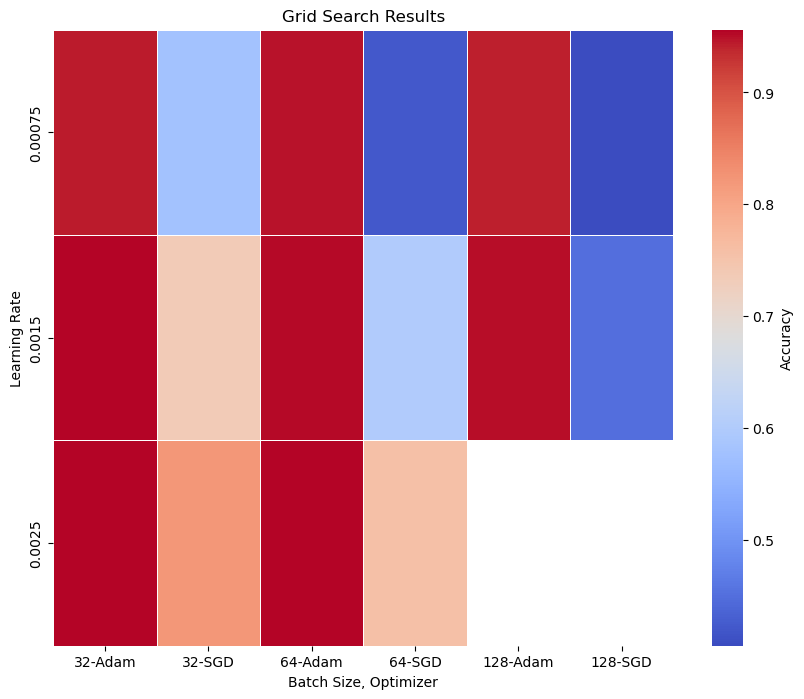

In [74]:
plot_grid_search_results('grid_search_results.csv')

### Look at the misclassified

In [42]:
def find_misclassified_train_indices(learner, device='cpu'):
    """
    Finds the indices of misclassified inputs along with their predicted and true labels.

    Args:
        learner (fastai.learner.Learner): The fastai learner object.
        device (str): The device to run the model on ('cpu' or 'cuda').

    Returns:
        tuple: A tuple containing three tensors:
            - misclassified_indices: Tensor of dataset indices of misclassified inputs.
            - predicted_labels: Tensor of predicted labels for misclassified inputs.
            - true_labels: Tensor of true labels for misclassified inputs.
    """
    dataloader = learner.dls.train
    model = learner.model

    # Ensure the model is in evaluation mode
    model.eval()
    
    misclassified_indices = []
    predicted_labels = []
    true_labels = []

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Get batch size
            batch_size = inputs.size(0)

            # Make predictions
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Compare predictions to true labels
            for i in range(batch_size):
                if predicted[i] != labels[i]:
                    # Calculate dataset index
                    dataset_index = batch_idx * batch_size + i
                    misclassified_indices.append(dataset_index)
                    predicted_labels.append([predicted[i].item()])
                    true_labels.append([labels[i].item()])  # Wrap the label in a list

    # Convert lists to tensors
    misclassified_indices = torch.tensor(misclassified_indices, dtype=torch.long)
    predicted_labels = torch.tensor(predicted_labels, dtype=torch.long)
    true_labels = torch.tensor(true_labels, dtype=torch.long)

    return misclassified_indices, predicted_labels, true_labels

In [43]:
learner: Learner = torch.load(learner_file_name)
misclassified_image_indexes_train, predicted_labels, true_labels = find_misclassified_train_indices(learner)

In [44]:
misclassified_images_train = X[misclassified_image_indexes_train]
misclassified_data_loader_train = list(zip(misclassified_images_train, true_labels, predicted_labels))

In [45]:
load_random_example(misclassified_data_loader_train)

label: 1
predicted: 3


In [46]:
misclassified_images_to_plot = [X[idx] for idx in misclassified_image_indexes_train]

predicted_labels_to_plot = predicted_labels[:10]
true_labels_to_plot = true_labels[:10]

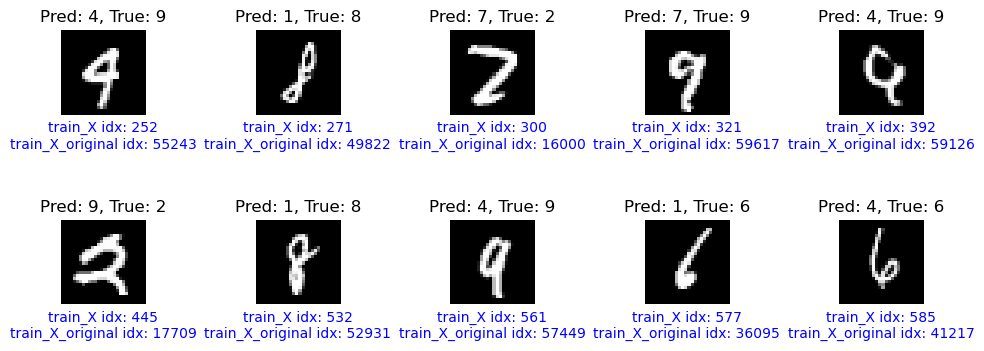

In [47]:
# Optionally, visualize some of the misclassified images
plot_images(misclassified_images_to_plot, misclassified_image_indexes_train, 1, true_labels, predicted_labels, index_mapping=train_inverse_index_mapping)

Lets do a sanity check to make sure we have the right indexes in our original training set. 

First lets look at the misclassified image in our (shuffled) train_X set

In [48]:
import random
image_indexes = misclassified_image_indexes_train
index_mapping = train_inverse_index_mapping

i = random.randint(0, image_indexes.shape[0])
training_set_index = image_indexes[i]
unshuffled_index = index_mapping[training_set_index]
train_X_idx_string = f"train_X idx: {training_set_index} (i.e. the shuffled index)"
print(train_X_idx_string)

image = X[training_set_index]
display_image(image)

train_X idx: 70863 (i.e. the shuffled index)


Now lets look at the image in the unshuffled set to verify that our mapping is correct

In [49]:
train_X_idx_string = f"train_X_original idx: {unshuffled_index} (i.e. the unshuffled/original index)"
print(train_X_idx_string)

image = train_X_original[unshuffled_index]
display_image(image)

train_X_original idx: 48986 (i.e. the unshuffled/original index)


Looks good!

Now we can write a function to get the original indexes from our misclassified

In [50]:
def get_original_indices(image_indexes, index_mapping):
    X_indices = []
    y_indices = []
    for i in range(len(image_indexes)):
        training_set_index = image_indexes[i]
        original_data_index = index_mapping[training_set_index]
        X_indices.append(original_data_index)
        y_indices.append(y[training_set_index])
    return X_indices, y_indices

In [51]:
original_indices_X, original_indices_y = get_original_indices(misclassified_image_indexes_train, train_inverse_index_mapping)

Now that we have the original indexes of the examples we got wrong lets save them to disk (we'll use them later on).

In [52]:
# if you want to include duplicates for the misclassified data then pass in the file name root here
misclassified_data_name = "misclassified"

In [53]:
save_to_disk(misclassified_data_name, original_indices_X, original_indices_y)

In [54]:
len(misclassified_images_train)

4724

### Improving our model

Let's see if we can improve on our best. To do this we will pass in the name of our misclassified data so that the function will supplement the original data with an additional copy of our misclassified examples.

In [76]:
(revised_train_X, revised_train_y, train_X_original, _), (revised_validate_X, revised_validate_y) = get_data(misclassified_data_name)
revised_train_X.shape, revised_train_y.shape, revised_validate_X.shape, revised_validate_y.shape

Loaded train data from disk
Loaded validate data from disk
Loaded misclassified data from disk


(torch.Size([194172, 784]),
 torch.Size([194172, 1]),
 torch.Size([10000, 784]),
 torch.Size([10000, 1]))

Now let's use the parameters from our best previous run to train a new model with the revised data.

In [56]:
# Load the results from the CSV file
df = pd.read_csv("grid_search_results.csv")
print(df.columns)

Index(['lr', 'batch_size', 'opt_func', 'n_epochs', 'runs', 'accuracy'], dtype='object')


In [57]:
best_params = df.iloc[df.accuracy.idxmax()]
best_params


lr            0.0025
batch_size        32
opt_func        Adam
n_epochs          11
runs               1
accuracy      0.9622
Name: 39, dtype: object

In [58]:
revised_learning_rate = float(best_params['lr'])
revised_batch_size = int(best_params['batch_size'])
revised_opt_func = Adam if best_params['opt_func'] == "Adam" else SGD
revised_n_epochs = int(best_params['n_epochs'])

But this time we will pass in the name of our misclassified data so that the function will supplement the original data with an additional copy of our misclassified examples.

In [77]:
revised_train_dataset = list(zip(revised_train_X,revised_train_y.long()))
revised_validate_dataset = list(zip(revised_validate_X, revised_validate_y.long()))
_, revised_val_accuracy = evaluate_model(revised_train_dataset, revised_validate_dataset, revised_learning_rate, revised_batch_size, revised_opt_func, revised_n_epochs)
print(f"Accuracy: {revised_val_accuracy}")

Initial accuracy: 0.1433


epoch,train_loss,valid_loss,batch_accuracy,time
0,1.560206,1.535407,0.929200,00:12
1,1.542929,1.527006,0.937500,00:14
2,1.532822,1.521348,0.942000,00:13
3,1.525583,1.519093,0.943300,00:15
4,1.523534,1.515229,0.947400,00:14
5,1.522282,1.522538,0.940300,00:14
6,1.518382,1.514260,0.949300,00:14
7,1.518531,1.517809,0.945600,00:14
8,1.514561,1.514869,0.949500,00:15
9,1.513598,1.517164,0.946800,00:17


Accuracy: 0.9474


Welp, that didn't work ¯\_(ツ)_/¯ 
    
I played around with the augmented data a bit but was not able to consistently beat the initial run.

Unfortunately I did not have time to dig into the issue further. Still it was a good exercise that we can build on in the future! 

In [82]:
import readme_ation

readme_ation.add_setup_with_versions(['lesson_3.ipynb'],"README.md")